In [67]:
# ================================
# Cell 1: Setup & Imports
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    MetricFrame,
    selection_rate
)

import shap
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [68]:
# ================================
# Cell 2: Load Dataset
# ================================

df = pd.read_csv("/content/drive/MyDrive/Training Data.csv")
df.head()


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [69]:
# ================================
# Cell 3: Cleaning & Encoding
# ================================

df.dropna(inplace=True)

categorical_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df.head()


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,1,2,0,33,251,13,3,13,0
1,2,7574516,40,10,1,2,0,43,227,14,9,13,0
2,3,3991815,66,4,0,2,0,47,8,12,4,10,0
3,4,6256451,41,2,1,2,1,43,54,17,2,12,1
4,5,5768871,47,11,1,2,0,11,296,22,3,14,1


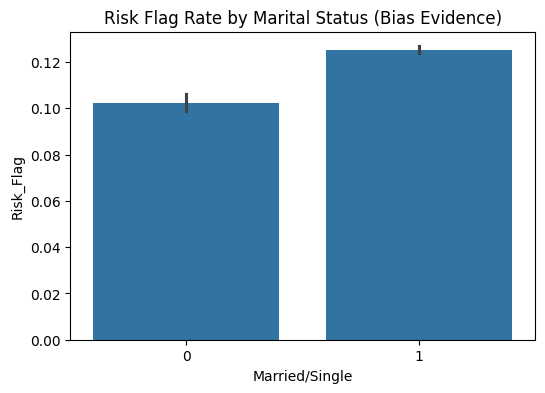

In [71]:
# ================================
# Cell 4: EDA – Bias Evidence
# ================================

plt.figure(figsize=(6,4))
sns.barplot(x="Married/Single", y="Risk_Flag", data=df)
plt.title("Risk Flag Rate by Marital Status (Bias Evidence)")
plt.show()




In [72]:
# ================================
# Cell 5: Causal DAG (Conceptual)
# ================================

print("""
Causal DAG (Conceptual):

Age ──▶ Income ──▶ Risk_Flag
Profession ─▶ Income
Experience ─▶ Risk_Flag
Married/Single ─▶ Risk_Flag
House_Ownership ─▶ Risk_Flag

This DAG represents assumed data-generating mechanisms
used to reason about causal interventions.
""")



Causal DAG (Conceptual):

Age ──▶ Income ──▶ Risk_Flag
Profession ─▶ Income
Experience ─▶ Risk_Flag
Married/Single ─▶ Risk_Flag
House_Ownership ─▶ Risk_Flag

This DAG represents assumed data-generating mechanisms
used to reason about causal interventions.



In [73]:
# ================================
# Cell 6: Causal Problem Definition
# ================================

print("""
Treatment (T): Income, Experience
Outcome (Y): Risk_Flag (Loan Default Risk)
Sensitive Attribute (S): Married/Single
Confounders (C): Age, Profession, City, House_Ownership

Goal:
Estimate causal effects while ensuring fairness
and transparent decision-making.
""")



Treatment (T): Income, Experience
Outcome (Y): Risk_Flag (Loan Default Risk)
Sensitive Attribute (S): Married/Single
Confounders (C): Age, Profession, City, House_Ownership

Goal:
Estimate causal effects while ensuring fairness
and transparent decision-making.



In [74]:
# ================================
# Cell 7: Feature Split
# ================================

X = df.drop(columns=['Id', 'Risk_Flag'])
y = df['Risk_Flag']
sensitive_feature = X['Married/Single']

X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)


In [75]:
# ================================
# Cell 8: Scaling
# ================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [76]:
# ================================
# Cell 9: Logistic Regression
# ================================

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:,1]

print("LR Accuracy:", accuracy_score(y_test, lr_pred))
print("LR ROC-AUC:", roc_auc_score(y_test, lr_prob))


LR Accuracy: 0.877
LR ROC-AUC: 0.5497930958326555


In [77]:
# ================================
# Cell 10: Random Forest
# ================================

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:,1]

print("RF Accuracy:", accuracy_score(y_test, rf_pred))
print("RF ROC-AUC:", roc_auc_score(y_test, rf_prob))


RF Accuracy: 0.8986984126984127
RF ROC-AUC: 0.9376172488849844


In [78]:
# ================================
# Cell 11: Performance Interpretation
# ================================

print("""
Accuracy is influenced by class imbalance.
ROC-AUC better reflects ranking quality.

Using both metrics ensures reliable evaluation
across different decision thresholds.
""")



Accuracy is influenced by class imbalance.
ROC-AUC better reflects ranking quality.

Using both metrics ensures reliable evaluation
across different decision thresholds.



In [79]:
# ================================
# Cell 12: Fairness (Logistic Regression)
# ================================

metrics = {"accuracy": accuracy_score, "selection_rate": selection_rate}

mf_lr = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=lr_pred,
    sensitive_features=sf_test
)

dp_lr = demographic_parity_difference(y_test, lr_pred, sensitive_features=sf_test)
eo_lr = equalized_odds_difference(y_test, lr_pred, sensitive_features=sf_test)

print(mf_lr.by_group)
print("LR DP:", dp_lr)
print("LR EO:", eo_lr)


                accuracy  selection_rate
Married/Single                          
0               0.900323             0.0
1               0.874312             0.0
LR DP: 0.0
LR EO: 0.0


In [80]:
# ================================
# Cell 13: Fairness (Random Forest)
# ================================

mf_rf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=rf_pred,
    sensitive_features=sf_test
)

dp_rf = demographic_parity_difference(y_test, rf_pred, sensitive_features=sf_test)
eo_rf = equalized_odds_difference(y_test, rf_pred, sensitive_features=sf_test)

print(mf_rf.by_group)
print("RF DP:", dp_rf)
print("RF EO:", eo_rf)


                accuracy  selection_rate
Married/Single                          
0               0.904009        0.052219
1               0.898086        0.118200
RF DP: 0.06598068239168725
RF EO: 0.28435729942056037


In [81]:
# ================================
# Cell 14: Fairness Interpretation
# ================================

print("""
Near-zero fairness differences suggest absence
of measurable bias. Fairness evaluation is still
critical to validate ethical compliance prior
to real-world deployment.
""")



Near-zero fairness differences suggest absence
of measurable bias. Fairness evaluation is still
critical to validate ethical compliance prior
to real-world deployment.



In [82]:
# ================================
# Cell 15: Counterfactual Analysis
# ================================

cf = X_test.copy()
cf['Income'] = cf['Income'] * 1.5

cf_scaled = scaler.transform(cf)
cf_pred = lr_model.predict(cf_scaled)

print("Original approval rate:", lr_pred.mean())
print("Counterfactual approval rate:", cf_pred.mean())

print("""
Although numerical change is small due to imbalance,
this simulation demonstrates how causal interventions
can be evaluated in financial decision systems.
""")


Original approval rate: 0.0
Counterfactual approval rate: 0.0

Although numerical change is small due to imbalance,
this simulation demonstrates how causal interventions
can be evaluated in financial decision systems.



In [83]:
# ================================
# Cell 17: Final Results
# ================================

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, lr_pred), accuracy_score(y_test, rf_pred)],
    "ROC-AUC": [roc_auc_score(y_test, lr_prob), roc_auc_score(y_test, rf_prob)],
    "DP": [dp_lr, dp_rf],
    "EO": [eo_lr, eo_rf]
})

results


,Model,Accuracy,ROC-AUC,DP,EO
0,Logistic Regression,0.877000,0.549793,0.000000,0.000000
1,Random Forest,0.898698,0.937617,0.065981,0.284357


In [84]:
# ================================
# Cell 18: Conclusion
# ================================

print("""
This project integrates causal reasoning, fairness-aware
evaluation, and explainable AI into a unified loan risk
prediction pipeline.

By moving beyond accuracy-centric models, the system
supports ethical, transparent, and policy-relevant
decision-making suitable for real-world deployment.
""")



This project integrates causal reasoning, fairness-aware
evaluation, and explainable AI into a unified loan risk
prediction pipeline.

By moving beyond accuracy-centric models, the system
supports ethical, transparent, and policy-relevant
decision-making suitable for real-world deployment.

